In [1]:
import gym, gym_unbalanced_disk, time

env = gym.make('unbalanced-disk-v0', dt=0.025, umax=4.) 
#env = gym_unbalanced_disk.UnbalancedDisk(dt=0.025, umax=4.) #alternative

# obs = env.reset()
# try:
#     for i in range(200):
#         obs, reward, done, info = env.step(env.action_space.sample()) #random action
#         print(obs,reward)
#         env.render()
#         time.sleep(1/24)
#         if done:
#             obs = env.reset()
# finally: #this will always run
#     env.close()

In [31]:
print(env.observation_space.shape)

(3,)


In [2]:
from gym import Wrapper
from gym import spaces
import numpy as np
from matplotlib import pyplot as plt
from collections import deque #a list with a fixed lenght
def argmax(a):
    #argmax([0,1,2,3]) -> 3
    #argmax([0,1,2,2]) -> 2 or 3 with equal probability of both (np.argmax would only return 2)
    #argmax([0,0,0,0]) -> 0, 1, 2 or 3 with equal probability of each (np.argmax would only return 0)
    a = np.array(a)
    return np.random.choice(np.arange(a.shape[0],dtype=int)[a==np.max(a)])

class histwrapper(Wrapper):
    def __init__(self, env, Nhist=7):
        super(histwrapper, self).__init__(env) #sets self.env
        
        shape = env.observation_space.shape #load the obs shape
        shapehist = (Nhist,) + shape #add (Nhist)
        h = env.observation_space.high*np.ones(shapehist) #the upperbounds
        l = env.observation_space.low*np.ones(shapehist) #the lowerbounds
        self.observation_space = spaces.Box(low=l.astype(np.float32),high=h.astype(np.float32)) #modify the observation_space
        self.hist = deque([],Nhist)
        self.Nhist = Nhist
        
    def step(self, action):
        observation, reward, done, info = self.env.step(action)
        self.hist.append(observation)
        observation = np.array(self.hist)
        return observation, reward, done, info

    def reset(self):
        observation = self.env.reset()
        self.hist.extend([observation]*self.Nhist)
        observation = np.array(self.hist)
        return observation
env = gym.make('unbalanced-disk-v0', dt=0.025, umax=4.) 

env = histwrapper(env, Nhist=4) #wrap the enviroment with the histwrapper
env.reset()
print(env.step(0))
print(env.step(0))

print(env.observation_space.shape)
print(env.action_space)
observation, reward, done, info = env.step(0)
print(observation)

(array([[ 0.00154111,  0.00071336],
       [ 0.00154111,  0.00071336],
       [ 0.00154111,  0.00071336],
       [ 0.0029655 , -0.00327856]]), 2.3408631365917485e-11, False, {})
(array([[ 0.00154111,  0.00071336],
       [ 0.00154111,  0.00071336],
       [ 0.0029655 , -0.00327856],
       [ 0.00161161, -0.00784934]]), 2.3355713616392786e-11, False, {})
(4, 2)
Box(-4.0, 4.0, (), float32)
[[ 0.00154111  0.00071336]
 [ 0.0029655  -0.00327856]
 [ 0.00161161 -0.00784934]
 [ 0.00103631 -0.01138011]]


In [3]:
def normalization(theta):
    return (theta+np.pi)%(2*np.pi) - np.pi

class Discretize_obs(gym.Wrapper):
    def __init__(self, env, nvec=10):
        super(Discretize_obs, self).__init__(env) #sets self.env
        if isinstance(nvec,int): #nvec in each dimention
            self.nvec = [nvec]*np.prod(env.observation_space.shape,dtype=int)
        else:
            self.nvec = nvec
        self.nvec = np.array(nvec) #(Nobs,) array
        
       # self.observation_space = gym.spaces.MultiDiscrete(self.nvec) #b)
        self.olow, self.ohigh = env.observation_space.low, env.observation_space.high #b)
        self.action_space = gym.spaces.Discrete(3) # discrete action space

    def discretize(self,observation): #b)
        return tuple(((observation - self.olow)/(self.ohigh - self.olow)*self.nvec).astype(int)) #b)
        
    def step(self, action):
        observation, reward, done, info = self.env.step([-3,0,3][action]) #b) # discrete action space
        return self.discretize(observation), reward, done, info #b)

    def reset(self):
        return self.discretize(self.env.reset()) #b)


env = gym.make('unbalanced-disk-sincos-v0', dt=0.025, umax=4.) 
env.reset()
print(env.step(0))
print(env.step(0)) #testing
print(env.step(0))
print(env.step(0))
print(env.step(0))
env = Discretize_obs(env,nvec=100)
env.reset()
print(env.step(0)) #testing
print(env.step(0))
print(env.step(0))
print(env.step(0))
print(env.step(2))
print(env.step(2))
print(env.step(2))

(array([-0.00125339,  0.99999921, -0.00521343]), 2.3238952821195086e-11, False, {})
(array([ 0.00173567,  0.99999849, -0.00562922]), 2.318576148245136e-11, False, {})
(array([ 0.00105826,  0.99999944, -0.00957252]), 2.3114038568397274e-11, False, {})
(array([ 2.05382925e-04,  9.99999979e-01, -8.97195796e-03]), 2.3030477730713217e-11, False, {})
(array([ 0.00117011,  0.99999932, -0.01055672]), 2.294221793063067e-11, False, {})
((48, 99, 47), 3.364455897320856e-11, False, {})
((45, 99, 45), 9.587532351095525e-11, False, {})
((40, 99, 44), 4.564027329338134e-10, False, {})
((33, 97, 42), 2.980422286324566e-09, False, {})
((29, 95, 47), 1.1495211540910698e-08, False, {})
((28, 95, 51), 1.375293798976911e-08, False, {})
((31, 96, 55), 5.503876036197304e-09, False, {})


In [4]:
def roll_mean(ar,start=2000,N=50): #smoothing if needed
    s = 1-1/N
    k = start
    out = np.zeros(ar.shape)
    for i,a in enumerate(ar):
        k = s*k + (1-s)*a
        out[i] = k
    return out

def Qlearn(env, nsteps=5000, callbackfeq=100, alpha=0.2,eps=0.2, gamma=0.99):
    from collections import defaultdict
    Qmat = defaultdict(float) #any new argument set to zero
    env_time = env
    while not isinstance(env_time,gym.wrappers.time_limit.TimeLimit):
        env_time = env_time.env
    ep_lengths = []
    angle = []
    theta = []
    rewards = []
    cum_rewards = []
    ep_lengths_steps = []
    cum_rew = 0
    
    obs = env.reset()
    print('goal reached time:')
    for z in range(nsteps):

        if np.random.uniform()<eps:
            action = env.action_space.sample()
        else:
            action = argmax([Qmat[obs,i] for i in range(env.action_space.n)])

        obs_new, reward1, done, info = env.step(action)

        if np.absolute(env.th) > 3 and env.omega < 0.1:
            reward = 10 + 2*np.exp(-(env.th%(2*np.pi)-np.pi)**2/(2*(np.pi/10)**2))-1
        elif np.absolute(env.th) < 1 and env.omega < 0.5:
            reward = -100 + 2*np.exp(-(env.th%(2*np.pi)-np.pi)**2/(2*(np.pi/10)**2))-1
        else:
            reward = 2*np.exp(-(env.th%(2*np.pi)-np.pi)**2/(2*(np.pi/10)**2))-1
        
        rewards.append(reward)
        cum_rew += reward
        cum_rewards.append(cum_rew)
        
        if done and not info.get('TimeLimit.truncated', False): #terminal state = done and not by timeout
            #saving results:
            print(env_time._elapsed_steps, end=' ')
            #ep_lengths.append(env_time._elapsed_steps)
            angle.append(np.amax(rewards))
            ep_lengths_steps.append(z)
            
            #updating Qmat:
            A = reward - Qmat[obs,action] # adventage or TD
            Qmat[obs,action] += alpha*A
            obs = env.reset()
            theta = []
        else: #done by timeout or not done
            A = reward + gamma*max(Qmat[obs_new, action_next] for action_next in range(env.action_space.n)) - Qmat[obs,action]
            Qmat[obs,action] += alpha*A
            obs = obs_new
            
            if info.get('TimeLimit.truncated',False): #done by timeout
                #saving results:
                #ep_lengths.append(env_time._elapsed_steps)
                angle.append(np.amax(rewards))
                ep_lengths_steps.append(z)
                #print('out', end=' ')
                print(np.amax(rewards))
                
                #reset:
                obs = env.reset()
                theta = []
    print()
    
    return Qmat, np.array(ep_lengths_steps), np.array(angle)


max_episode_steps = 1000 #c)
env = gym.make('unbalanced-disk-sincos-v0', dt=0.025, umax=4.)  #c)
env = gym.wrappers.time_limit.TimeLimit(env,max_episode_steps=max_episode_steps) #c)
env = Discretize_obs(env,nvec=20) #c)

    #print('alpha=',alpha) #c)
Qmat, ep_lengths_steps, ep_lengths = Qlearn(env, nsteps=50000, callbackfeq=5000, alpha=0.7,eps=0.1, gamma=0.99 ) #c=)
plt.plot(ep_lengths_steps,roll_mean(ep_lengths,start=-1),label=str(alpha)) #c)
plt.legend() #c)
plt.title("Learning rate optimisation")
plt.xlabel("Number of learning steps")
plt.ylabel("Maximum reward of episode (rolling mean)")
plt.show() #c)

goal reached time:
-0.9999999980721486
-0.9999996274965178
-0.9997661153977121
-0.9997661153977121
-0.9997661153977121
-0.9997661153977121
-0.9997661153977121
-0.9997661153977121
-0.9996119051702373
-0.9996119051702373
-0.9996119051702373
-0.9996119051702373
-0.9884580433268316
-0.9884580433268316
-0.9884580433268316
-0.9746659683843633
-0.9746659683843633
-0.7895909376324013
-0.7895909376324013
-0.7895909376324013
-0.7895909376324013
-0.7895909376324013
9.055420225517306
10.909460199061051
10.998904617733201
10.998904617733201
10.998904617733201
10.998904617733201
10.998904617733201
10.998904617733201
10.998904617733201
10.998904617733201
10.998904617733201
10.998904617733201
10.998904617733201
10.998904617733201
10.9996201561497
10.9996201561497
10.9996201561497
10.9996201561497
10.9996201561497
10.9996201561497
10.9996201561497
10.999791417021848
10.999791417021848
10.999791417021848
10.999791417021848
10.999791417021848
10.999791417021848
10.999791417021848
10.999791417021848
10.99

NameError: name 'alpha' is not defined

No handles with labels found to put in legend.


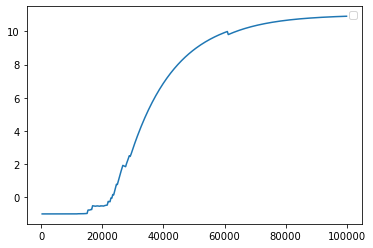

In [36]:
plt.plot(ep_lengths_steps,roll_mean(ep_lengths,start=-1)) #c)
plt.legend() #c)
plt.show() #c)

In [14]:
from gym.wrappers import Monitor
env = Monitor(gym.make('unbalanced-disk-sincos-v0', dt=0.025, umax=4.), './video', force=True)

#env = gym.make('unbalanced-disk-sincos-v0', dt=0.025, umax=4.)
env = gym.wrappers.time_limit.TimeLimit(env,max_episode_steps=max_episode_steps) #c)
env = Discretize_obs(env,nvec=20) #c)


theta = []
omega = []
rewards = []
cum_rew = 0
cum_rewards = []

obs = env.reset()
try:
    env.render()
    done=False
    while done==False:
        action = argmax([Qmat[obs,i] for i in range(env.action_space.n)])
        obs, reward, done, info = env.step(action)
        theta.append(normalization(env.th))
        omega.append(env.omega)
        rewards.append(reward)
        cum_rew += reward
        cum_rewards.append(cum_rew)
        env.render()
        time.sleep(1/60)
        print(obs,reward,action,done,info) #check info on timelimit
        #check on info['TimeLimit.truncated']
finally:
    env.close()

(10, 19, 10) 3.2684461505148395e-11 2 False {}
(10, 19, 10) 9.347550230425599e-11 2 False {}
(11, 19, 11) 4.473897638096369e-10 2 False {}
(13, 19, 10) 2.0971230113718694e-09 1 False {}
(13, 19, 10) 4.475767815805192e-09 0 False {}
(13, 19, 9) 3.2437043583241125e-09 0 False {}
(12, 19, 9) 1.2036671457515098e-09 1 False {}
(11, 19, 9) 3.470542041919047e-10 1 False {}
(10, 19, 8) 5.898189052400847e-11 0 False {}
(8, 19, 8) 1.0950246421849584e-10 0 False {}
(7, 19, 7) 1.8453422673176863e-09 0 False {}
(5, 18, 7) 3.104199212795248e-08 0 False {}
(3, 17, 7) 4.1568476045903594e-07 0 False {}
(2, 16, 8) 3.863817204695109e-06 0 False {}
(1, 14, 8) 2.359552532270136e-05 0 False {}
(0, 13, 9) 7.52397713500121e-05 1 False {}
(0, 13, 9) 0.00010906697591850466 1 False {}
(0, 13, 10) 7.782352116098838e-05 1 False {}
(1, 14, 11) 2.7814669471234287e-05 1 False {}
(1, 15, 11) 6.349948606814789e-06 0 False {}
(3, 17, 12) 7.037493444615789e-07 2 False {}
(5, 18, 13) 2.0703843313205703e-08 2 False {}
(8, 

(5, 18, 4) 3.674493591619539e-08 0 False {}
(1, 15, 5) 1.0575310358911008e-05 1 False {}
(0, 11, 6) 0.0005539185404785757 0 False {}
(0, 8, 6) 0.008924081467361318 0 False {}
(1, 5, 7) 0.05188488727540998 1 False {}
(2, 3, 8) 0.1402396586137349 1 False {}
(3, 2, 9) 0.23936353654967374 1 False {}
(3, 2, 9) 0.3342398145658442 0 False {}
(4, 1, 9) 0.4406292110796977 0 False {}
(5, 1, 9) 0.5597101318515665 0 False {}
(6, 0, 8) 0.6917956272814852 0 False {}
(7, 0, 9) 0.8023183193798182 1 False {}
(7, 0, 9) 0.892681626431595 0 False {}
(8, 0, 8) 0.974059722164464 0 False {}
(9, 0, 9) 0.9998762970814631 2 False {}
(10, 0, 9) 0.9915392520429264 1 False {}
(11, 0, 9) 0.9754079553251352 2 False {}
(11, 0, 9) 0.9474773162512576 0 False {}
(12, 0, 8) 0.8548413685672772 0 False {}
(13, 0, 8) 0.7151761513881951 2 False {}
(14, 1, 9) 0.5971570394712764 2 False {}
(15, 1, 8) 0.4739991602060298 1 False {}
(16, 2, 9) 0.34934806907862065 2 False {}
(17, 2, 8) 0.20914009103668552 0 False {}
(18, 4, 7) 0.0

In [6]:
frames

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,

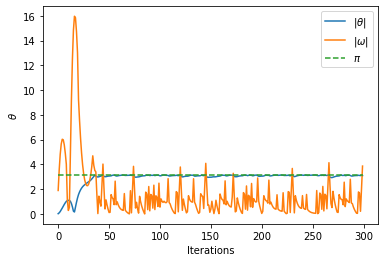

No handles with labels found to put in legend.


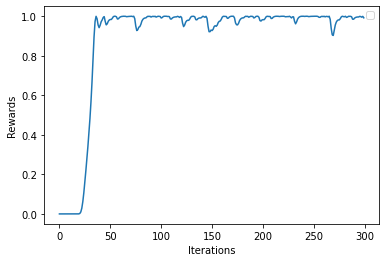

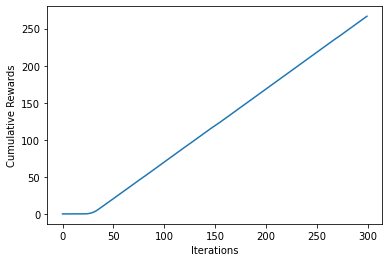

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(np.abs(theta),label='$|\\theta|$')
plt.plot(np.abs(omega),label='$|\omega|$')
plt.plot([np.pi]*len(theta),'--',label='$\pi$')
plt.xlabel('Iterations')
plt.ylabel(r'$\theta$')
plt.legend()
plt.show()

plt.plot(rewards)
plt.xlabel('Iterations')
plt.ylabel('Rewards')
plt.legend()
plt.show()

plt.plot(cum_rewards)
plt.xlabel('Iterations')
plt.ylabel('Cumulative Rewards')
plt.show()

Text(0.5, 0, 'Angle (rad)')

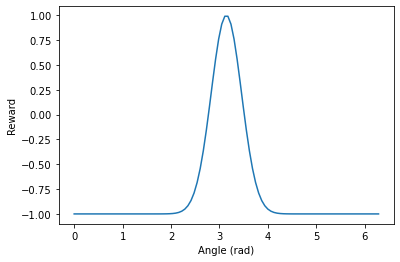

In [6]:
x = np.linspace(0,2*np.pi,100)
#r = np.exp(-(x%(2*np.pi)-np.pi)**2/(2*(np.pi/7)**2))
r = 2*np.exp(-(x%(2*np.pi)-np.pi)**2/(2*(np.pi/10)**2))-1
#r = -2/3*(np.cos(x))
plt.plot(x,r)
plt.ylabel('Reward')
plt.xlabel('Angle (rad)')

In [17]:
Qmat

defaultdict(float,
            {((14, 29, 14), 0): -684.2867246702735,
             ((14, 29, 14), 1): -690.0438573147701,
             ((14, 29, 14), 2): -706.4528953942515,
             ((14, 29, 14), 3): -705.617988314823,
             ((14, 29, 14), 4): -692.6196771326612,
             ((14, 29, 14), 5): -700.1758392364759,
             ((14, 29, 14), 6): -597.27228026237,
             ((15, 29, 15), 0): -716.3338200298492,
             ((15, 29, 15), 1): -716.8531054599155,
             ((15, 29, 15), 2): -694.5040646046893,
             ((15, 29, 15), 3): -692.5457368449785,
             ((15, 29, 15), 4): -639.9917984989138,
             ((15, 29, 15), 5): -589.5258115879269,
             ((15, 29, 15), 6): -615.0591158062747,
             ((16, 29, 16), 0): -706.8576453461446,
             ((16, 29, 16), 1): -659.1082972277638,
             ((16, 29, 16), 2): -661.4482582270987,
             ((16, 29, 16), 3): -650.0385462960539,
             ((16, 29, 16), 4): -663.50806873328

In [9]:
from scipy.io import savemat
savemat("qmat.mat", Qmat)

AttributeError: 'tuple' object has no attribute 'encode'

In [117]:
import pickle
with open('Qmat_opt_tabular.p','wb') as Q_function:
    pickle.dump(Qmat,Q_function)

In [3]:
import pickle

In [11]:
with open('Qmat_best_policy.p','rb') as f:
    Q = pickle.load(f)

In [12]:
obs = env.reset()
try:
    env.render()
    done=False
    while done==False:
        action = argmax([Q[obs,i] for i in range(env.action_space.n)])
        obs, reward, done, info = env.step(action)
        env.render()
        time.sleep(1/24)
        #print(obs,reward,action,done,info) #check info on timelimit
        print(np.absolute(env.th*180/np.pi))
        #check on info['TimeLimit.truncated']
finally:
    env.close()

1.3685488729233504
2.5324447509637253
2.0827357323666953
1.5030083969383405
0.5350578508738233
5.140016803006656
10.428257277459732
14.610948875878481
16.06617452354715
14.882213555527354
11.277558135067492
5.6942686296099465
0.021537362547528388
3.9273770977532063
7.367964657332076
11.395297022330878
12.941596808568287
12.07205565122175
11.729790141980596
10.499095182653138
8.582823697677595
6.108194936704853
1.9721082063231241
2.061127385192855
4.31302580815488
3.3706527888153976
0.5003861379155428
5.449301424006312
8.305685039082457
10.391216886855544
11.539928094530888
9.020446807584957
4.624037230583863
0.14632473956491837
5.449859384674374
10.265636220893823
14.045237389546758
16.515111179297136
17.63184111611046
17.33968042738744
15.80288951250313
15.912017718552601
16.17852391888749
13.841385612592001
9.258983719964062
5.63919192907148
4.545761600391733
3.1469731843316953
1.1357981107515387
7.803457998857982
16.209557098402424
22.867851428537
24.704848574891763
24.6475087926739